# Sensor Drift & Anomaly Detector (pandas + NumPy)

You are given time-series readings from several temperature sensors in a lab. Each sensor should report values around its own baseline, but over time some sensors drift or produce spikes.

Your job is to:

- clean the data,
- compute drift and anomalies using NumPy,
- summarise results with pandas (no row-by-row loops).


## 1. Warm-Up Tasks

### 1.1 Load & Standardise
- Load dataset.
- Convert `timestamp` to datetime.
- Standardise `location` (lowercase + strip spaces).

### 1.2 Clean Missing Readings
Choose one:
- Drop rows with missing `reading_c`.
- Impute missing `reading_c` with per-sensor mean.

### 1.3 Compute Drift
- Add column `drift_c = reading_c - baseline_c`.

## 2. Core Tasks

### 2.1 Per-Sensor Drift Statistics
Create summary:
```
sensor_id | mean_drift_c | std_drift_c | fraction_positive_drift
```

### 2.2 Z-Scores & Anomalies
- Compute per-sensor `drift_z = (drift_c - mean_drift_c) / std_drift_c`.
- Create `is_anomaly = abs(drift_z) >= 2.5`.

Produce:
```
sensor_id | n_readings | n_anomalies | pct_anomalies
```

and
```
location | n_anomalies
```

### 2.3 Drift Trend Over Time
- Group or resample by hour.
- Compute:
```
timestamp_hour | mean_drift_c_all_sensors
```

## 3. Acceptance Checks
- `timestamp` is datetime.
- No missing `reading_c`.
- One row per sensor in anomaly summary.
- Total anomalies match across sensors and locations.
- No row-level loops used.

## 4. Optional Stretch Goals
- Global z-scores vs per-sensor z-scores.
- Clip drift using NumPy and recompute anomalies.
- Plot drift over time for one sensor with anomalies marked.


## Libraries

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

## Generate data

In [2]:
def generate_sensor_dataset(n_sensors=4, hours=24, seed=42):
    np.random.seed(seed)

    sensor_ids = [chr(ord('A') + i) for i in range(n_sensors)]
    baselines = {sid: np.random.uniform(18, 22) for sid in sensor_ids}
    locations = ["Lab1", " lab1 ", "LAB2", "Lab_3  ", " lab2"]

    rows = []

    for sid in sensor_ids:
        baseline = baselines[sid]
        timestamps = pd.date_range("2025-01-01 00:00", periods=hours, freq="H")

        # Temperature drift: random walk around baseline
        drift = np.cumsum(np.random.normal(0, 0.2, size=hours))
        readings = baseline + drift + np.random.normal(0, 0.3, size=hours)

        # Inject some missing readings
        missing_idx = np.random.choice(hours, size=2, replace=False)
        readings[missing_idx] = np.nan

        for ts, r in zip(timestamps, readings):
            rows.append({
                "sensor_id": sid,
                "timestamp": ts,
                "reading_c": r,
                "baseline_c": baseline,
                "location": np.random.choice(locations)
            })

    df = pd.DataFrame(rows)
    return df


# Example usage
df = generate_sensor_dataset()
df


/var/folders/vx/4t7xz04d6_39xszmh_6hq4br0000gn/T/ipykernel_56904/3104217359.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range("2025-01-01 00:00", periods=hours, freq="H")


,sensor_id,timestamp,reading_c,baseline_c,location
0,A,2025-01-01 00:00:00,19.271138,19.498160,lab2
1,A,2025-01-01 01:00:00,19.316994,19.498160,LAB2
2,A,2025-01-01 02:00:00,19.539833,19.498160,Lab_3
3,A,2025-01-01 03:00:00,20.429515,19.498160,LAB2
4,A,2025-01-01 04:00:00,19.775888,19.498160,LAB2
...,...,...,...,...,...
91,D,2025-01-01 19:00:00,19.973835,20.394634,LAB2
92,D,2025-01-01 20:00:00,20.030805,20.394634,Lab1
93,D,2025-01-01 21:00:00,20.135140,20.394634,Lab_3
94,D,2025-01-01 22:00:00,20.433311,20.394634,lab1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   sensor_id   96 non-null     object        
 1   timestamp   96 non-null     datetime64[ns]
 2   reading_c   88 non-null     float64       
 3   baseline_c  96 non-null     float64       
 4   location    96 non-null     object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 3.9+ KB


## 1. Warm-Up Tasks

### 1.1 Load & Standardise
- Load dataset.
- Convert `timestamp` to datetime.
- Standardise `location` (lowercase + strip spaces).

### 1.2 Clean Missing Readings
Choose one:
- Drop rows with missing `reading_c`.
- Impute missing `reading_c` with per-sensor mean.

### 1.3 Compute Drift
- Add column `drift_c = reading_c - baseline_c`.

In [4]:
# Convert timestamp to datetime
df['datetime'] = pd.to_datetime(df['timestamp'])

# Standardise location

def simple_text(text):
    text =  text.lower().strip()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[_]', '', text)
    return text

df['location_standard'] = df['location'].apply(simple_text)

# Impute missing readings with per-sensor mean
sensor_mean = df.groupby("sensor_id")["reading_c"].transform("mean")
df["reading_c"] = df["reading_c"].fillna(sensor_mean)

# Compute drift

df['drift_c'] = df['reading_c'] - df['baseline_c']



In [5]:
df

,sensor_id,timestamp,reading_c,baseline_c,location,datetime,location_standard,drift_c
0,A,2025-01-01 00:00:00,19.271138,19.498160,lab2,2025-01-01 00:00:00,lab2,-0.227022
1,A,2025-01-01 01:00:00,19.316994,19.498160,LAB2,2025-01-01 01:00:00,lab2,-0.181166
2,A,2025-01-01 02:00:00,19.539833,19.498160,Lab_3,2025-01-01 02:00:00,lab3,0.041673
3,A,2025-01-01 03:00:00,20.429515,19.498160,LAB2,2025-01-01 03:00:00,lab2,0.931355
4,A,2025-01-01 04:00:00,19.775888,19.498160,LAB2,2025-01-01 04:00:00,lab2,0.277727
...,...,...,...,...,...,...,...,...
91,D,2025-01-01 19:00:00,19.973835,20.394634,LAB2,2025-01-01 19:00:00,lab2,-0.420799
92,D,2025-01-01 20:00:00,20.030805,20.394634,Lab1,2025-01-01 20:00:00,lab1,-0.363829
93,D,2025-01-01 21:00:00,20.135140,20.394634,Lab_3,2025-01-01 21:00:00,lab3,-0.259494
94,D,2025-01-01 22:00:00,20.433311,20.394634,lab1,2025-01-01 22:00:00,lab1,0.038677


## 2.1 Per-Sensor Drift Statistics
Create summary:
```
sensor_id | mean_drift_c | std_drift_c | fraction_positive_drift
```

In [6]:
df.groupby(by = 'sensor_id').agg(mean_drif_c = ('drift_c', 'mean'),
                                 std_drift_c = ('drift_c', 'std'),
                                 fraction_positive_drift=("drift_c", lambda s: (s > 0).mean())
                                 )

,mean_drif_c,std_drift_c,fraction_positive_drift
sensor_id,,,
A,-0.587406,0.720108,0.250000
B,-0.190581,0.413765,0.375000
C,-0.288637,0.562600,0.333333
D,-0.125869,0.399043,0.416667


## 2.2 Z-Scores & Anomalies
- Compute per-sensor `drift_z = (drift_c - mean_drift_c) / std_drift_c`.
- Create `is_anomaly = abs(drift_z) >= 2.5`.

Produce:
```
sensor_id | n_readings | n_anomalies | pct_anomalies
```

and
```
location | n_anomalies
```

In [7]:
df['drift_mean'] = df.groupby("sensor_id")["drift_c"].transform("mean")
df['drift_std'] = df.groupby("sensor_id")["drift_c"].transform("std")
df['drift_z'] = (df['drift_c'] - df['drift_mean'])/df['drift_std']
df['anomaly'] = abs(df['drift_z']) >= 1

In [8]:
df

,sensor_id,timestamp,reading_c,baseline_c,location,datetime,location_standard,drift_c,drift_mean,drift_std,drift_z,anomaly
0,A,2025-01-01 00:00:00,19.271138,19.498160,lab2,2025-01-01 00:00:00,lab2,-0.227022,-0.587406,0.720108,0.500458,False
1,A,2025-01-01 01:00:00,19.316994,19.498160,LAB2,2025-01-01 01:00:00,lab2,-0.181166,-0.587406,0.720108,0.564138,False
2,A,2025-01-01 02:00:00,19.539833,19.498160,Lab_3,2025-01-01 02:00:00,lab3,0.041673,-0.587406,0.720108,0.873590,False
3,A,2025-01-01 03:00:00,20.429515,19.498160,LAB2,2025-01-01 03:00:00,lab2,0.931355,-0.587406,0.720108,2.109075,True
4,A,2025-01-01 04:00:00,19.775888,19.498160,LAB2,2025-01-01 04:00:00,lab2,0.277727,-0.587406,0.720108,1.201395,True
...,...,...,...,...,...,...,...,...,...,...,...,...
91,D,2025-01-01 19:00:00,19.973835,20.394634,LAB2,2025-01-01 19:00:00,lab2,-0.420799,-0.125869,0.399043,-0.739093,False
92,D,2025-01-01 20:00:00,20.030805,20.394634,Lab1,2025-01-01 20:00:00,lab1,-0.363829,-0.125869,0.399043,-0.596327,False
93,D,2025-01-01 21:00:00,20.135140,20.394634,Lab_3,2025-01-01 21:00:00,lab3,-0.259494,-0.125869,0.399043,-0.334864,False
94,D,2025-01-01 22:00:00,20.433311,20.394634,lab1,2025-01-01 22:00:00,lab1,0.038677,-0.125869,0.399043,0.412350,False


In [9]:
df.groupby(by = 'sensor_id').agg(n_readings = ('reading_c', 'count'),
                                 n_anomalies = ('anomaly', 'sum'),
                                 pct_anomalies = ('anomaly', 'mean'))

,n_readings,n_anomalies,pct_anomalies
sensor_id,,,
A,24,8,0.333333
B,24,7,0.291667
C,24,9,0.375000
D,24,7,0.291667


In [10]:
df.groupby(by = 'location_standard').agg(n_anomalies = ('anomaly', 'sum'))

,n_anomalies
location_standard,
lab1,13
lab2,12
lab3,6


## 2.3 Drift Trend Over Time
- Group or resample by hour.
- Compute:
```
timestamp_hour | mean_drift_c_all_sensors
```

In [11]:
df['timestamp_hour'] = df['datetime'].dt.hour
drift_trend = df.groupby(by = 'timestamp_hour').agg(mean_drift_c = ('drift_c', 'mean'))
drift_trend

,mean_drift_c
timestamp_hour,
0,0.130168
1,-0.354587
2,-0.262173
3,0.211243
4,0.098445
5,-0.081312
6,-0.056458
7,-0.144272
8,0.196159


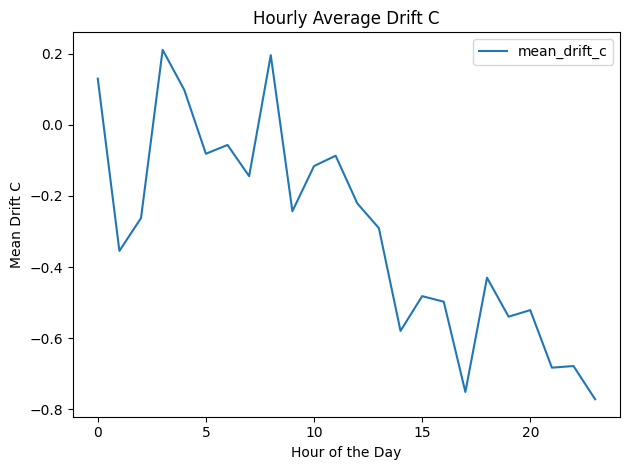

In [12]:
drift_trend.plot()
plt.ylabel('Mean Drift C')
plt.xlabel('Hour of the Day')
plt.title('Hourly Average Drift C')
plt.tight_layout()

## 4. Optional Stretch Goals
- Global z-scores vs per-sensor z-scores.
- Clip drift using NumPy and recompute anomalies.
- Plot drift over time for one sensor with anomalies marked.

### Global z-scores

In [13]:
df['global_mean'] = df["drift_c"].mean()
df['global_std'] = df["drift_c"].std()
df['global_drift_z'] = (df['drift_c'] - df['global_mean'])/df['global_std']

In [14]:
df['global_anomaly'] = abs(df['global_drift_z']) >= 1
df['local_anomaly'] = abs(df['drift_z']) >= 1

df[['global_anomaly', 'local_anomaly']].mean()


global_anomaly    0.333333
local_anomaly     0.322917
dtype: float64

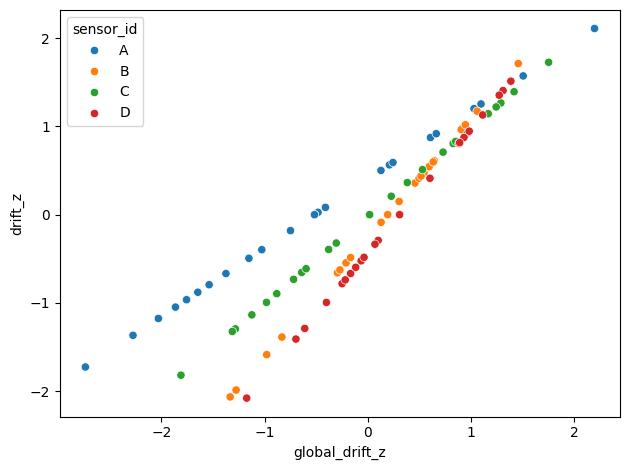

In [15]:
import seaborn as sns

sns.scatterplot(
    data = df,
    x = 'global_drift_z',
    y = 'drift_z',
    hue = 'sensor_id'
)

plt.tight_layout()

### Recompute anomalies

<Axes: xlabel='drift_c', ylabel='Count'>

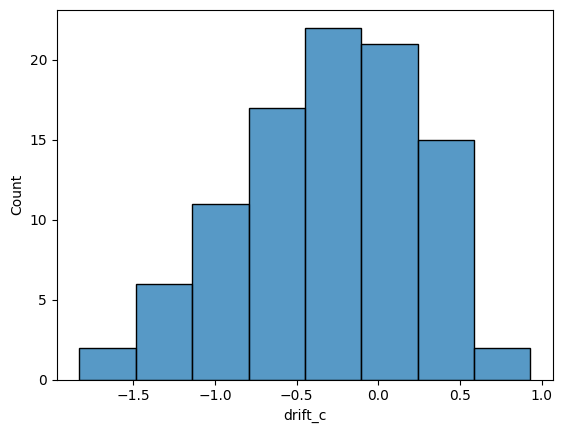

In [16]:
sns.histplot(
    data = df,
    x = 'drift_c'
)

In [17]:
lower_clip = -1.5
upper_clip = 1.5

df['drift_c_clipped'] = df['drift_c'].apply(lambda x: lower_clip if x < lower_clip else upper_clip if x>upper_clip else x)

<Axes: xlabel='drift_c_clipped', ylabel='Count'>

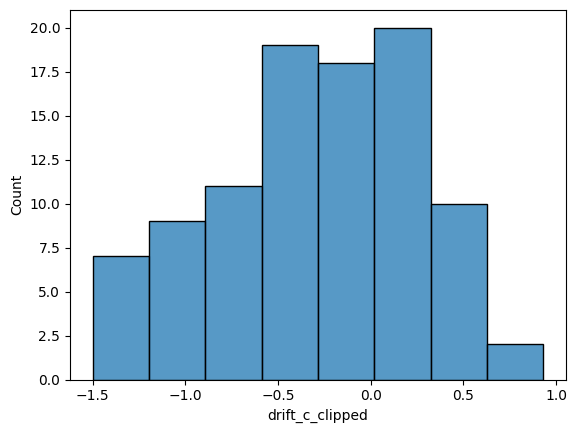

In [18]:
sns.histplot(
    data = df,
    x = 'drift_c_clipped'
)

In [19]:
df['drift_mean_new'] = df.groupby("sensor_id")["drift_c_clipped"].transform("mean")
df['drift_std_new'] = df.groupby("sensor_id")["drift_c_clipped"].transform("std")
df['drift_z_new'] = (df['drift_c_clipped'] - df['drift_mean_new'])/df['drift_std_new']
df['anomaly_new'] = abs(df['drift_z_new']) >= 1

In [20]:
df.groupby(by = 'sensor_id').agg(n_readings = ('reading_c', 'count'),
                                 n_anomalies = ('anomaly', 'sum'),
                                 pct_anomalies = ('anomaly', 'mean'),
                                 n_anomalies_new = ('anomaly_new', 'sum'),
                                 pct_anomalies_new = ('anomaly_new', 'mean'))

,n_readings,n_anomalies,pct_anomalies,n_anomalies_new,pct_anomalies_new
sensor_id,,,,,
A,24,8,0.333333,9,0.375000
B,24,7,0.291667,7,0.291667
C,24,9,0.375000,9,0.375000
D,24,7,0.291667,7,0.291667


### Plot drift over time for one sensor with anomalies marked.

<Axes: xlabel='timestamp_hour', ylabel='drift_c'>

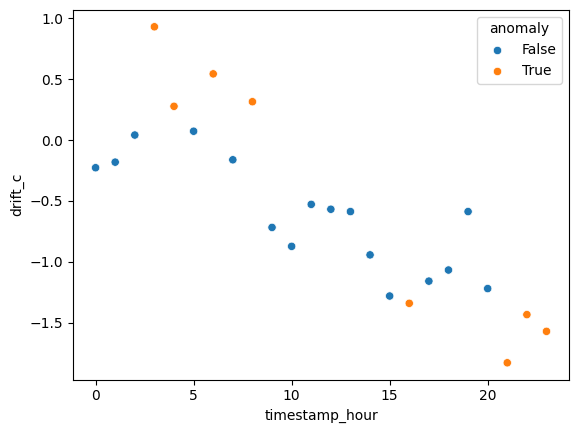

In [29]:
sensor = df[df['sensor_id'] == 'A']

sns.scatterplot(
    data = sensor,
    x = 'timestamp_hour',
    y = 'drift_c',
    hue = 'anomaly'
)

# === End of Challenge ===